# Week 8: Introduction to Artificial Neural Networks with Keras

This notebook is heavily inspired by Andre Guernon work, that can be found here: https://github.com/ageron/handson-ml/blob/master/10_introduction_to_artificial_neural_networks.ipynb

## Setup

In [ ]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 8)

# Scikit-Learn ≥ 1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1.  A quick overview of Tensorflow

In [ ]:
## Install dependencies
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version', tf.__version__)
print('Keras version', keras.__version__)
warnings.filterwarnings(action="ignore", message="^NUMA")

#### 1.0.1 Only if you have a GPU-enabled TensorFlow

If you run TensorFlow on a GPU you may need to run the cell below to limit the GPU memory growth.

See more details on TensorFlow's documentation: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

### 1.1 `tf.Tensor` - Tensors in TensorFlow

What is a tensor? Just a generalization of the concept of vectors beyond the 1-dimensional case. Matrices are 2-dimensional tensors, and so on. 

You can see Tensorflow's tensors as equivalent to NumPy ndarrays. The main difference is that by default they store 32-bit floating point numbers rather than 64-bit ones. Moreover, Tensorflow's tensors are immutable.

In [ ]:
tf.constant([[10., 20., 30.], [40., 50., 60.]]) # matrix

A 0-dimensional tensor is just a scalar.

In [ ]:
tf.constant(42) # scalar

We can create a tensor out of a list (or a list or list) just as we did for NumPy arrays.

In [ ]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.], [7., 8., 9.]])
t.shape

In [ ]:
t.dtype

### 1.2 Tensor Indexing

In [ ]:
t[:, 1:3]

In [ ]:
t[..., 1:3, tf.newaxis]

### 1.3 Tensor Operations

Let's see how we can implement addition, element exponential, and matrix multiplication.

In [ ]:
# addition
t + 11

In [ ]:
# element-wise exponential
tf.math.exp(t)

In [ ]:
# matrix exponential. See http://mathworld.wolfram.com/MatrixExponential.html 
tf.linalg.expm(t)

**Exercise 0:** multiply the matrix `t` for its transpose (matrix multiplication)
Hint. You can also use the new matrix multiplication operator `@` if you have Python 3.5 or greater (which you should have): https://docs.python.org/3/whatsnew/3.5.html#whatsnew-pep-465

In [ ]:
# Write your solution here: matrix multiplication
t @ tf.transpose(t)

### 1.4 Tensorflow Tensors and NumPy Arrays

Coversions are very easy.

In [ ]:
arr = t.numpy()
arr

In [ ]:
tf.constant(arr)

In [ ]:
np.array(t)

### 1.5 tf.Variable

A `tf.Variable` object is just a mutable `tf.Tensor`. This can be used to store learned parameters such as connection weights and biases.

In [ ]:
v = tf.Variable(t)
v

In [ ]:
v.assign_add(t)
v

### 1.5 Tensor Arrays

In [ ]:
# Write value into index index of the TensorArray.
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [ ]:
# Read the value at location index in the TensorArray.
array.read(1)

In [ ]:
# Return the values in the TensorArray as a stacked Tensor.
array.stack()

## 2. Implementing MLPs with Keras: an Image Classifier using the Sequential API

We will now see how we can implement, train, and validate a Multi-layer Perceptron (MLP) using Keras (as a submodule of TensorFlow).

We will use as dataset the popular Fashion MNIST dataset (https://www.kaggle.com/datasets/zalando-research/fashionmnist)

### 6.1.2 Load the Fashion MNIST dataset with Keras

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(
    X_train_full, y_train_full
), (
    X_test, y_test
) = fashion_mnist.load_data()
# There are 10 classes in the Fashion MNIST dataset
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [4]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

We can use `imshow()` from matplotlib to display one or more of the images in the training set.

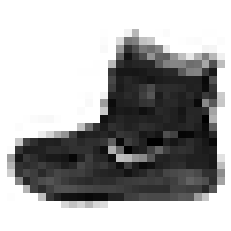

In [5]:
plt.imshow(X_train_full[0], cmap="binary")
plt.axis('off')
plt.show()

In [6]:
y_train_full[1]

0

Here, we perform a rough min-max scaling.

In [7]:
X_train_full.max()

255

In [8]:
X_diff = X_train_full.max() - X_train_full.min()
print('X_diff = ', X_diff)
X_valid, X_train = X_train_full[:5000]/X_diff, X_train_full[5000:]/X_diff
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_diff =  255


In [9]:
X_train.max()

1.0

In [10]:
class_names[y_train[0]]

'Coat'

### 6.1.3 Create a Sequential Model with Keras

Now we can just create our Deep Neural Network using the `Sequential` model.

**Exercise 1:** complete the sequential model below. You will have to add two hidden `Dense` layers (with 300 and 100 nodes respectively and a suitable activation function) and one `Dense` output layer with an appropriare number of output nodes and an appropriate activation function. 
If it can help you, check:
- `tf.keras` documentation about the `Sequential` class how to use it to build a MLP network: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- `tf.keras.layers` documentation about the `Dense` layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers 

In [11]:
# Complete the code here:
n_net = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # this input layer just flattens our 28x28 images
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
]) 

2022-07-15 17:28:20.641867: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-15 17:28:20.641898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pc323
2022-07-15 17:28:20.641904: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pc323
2022-07-15 17:28:20.642031: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-07-15 17:28:20.642050: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-07-15 17:28:20.642056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5
2022-07-15 17:28:20.642384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operatio

In [12]:
n_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Once you have correctly initialized your network/model, you can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name:

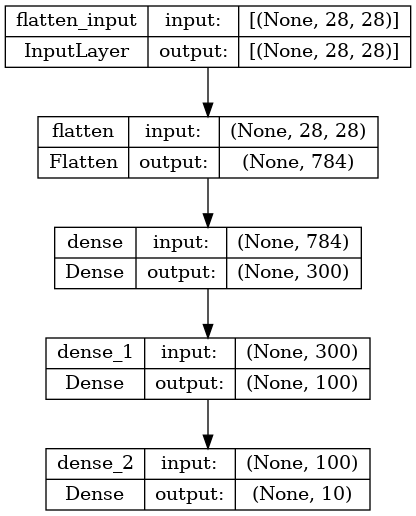

In [13]:
keras.utils.plot_model(
    n_net,
    "fully-connected-nn.png",
    show_shapes=True
)

In [20]:
n_net.layers

In [21]:
first_hidden_layer = n_net.layers[1]
first_hidden_layer

In [ ]:
first_hidden_layer = n_net.get_layer('dense_4')
weights, biases = first_hidden_layer.get_weights()

In [ ]:
weights, weights.shape

In [ ]:
biases, biases.shape

Notice that the Dense layer initialized the connection weights randomly and the biases were initialized to zeros, which is fine.

### 6.1.3 Compile the Sequential Model with Keras

Once you have created a model, you must call its `compile()` method to specify the loss function and the optimizer to use. You can also optionally specify a list of extra metrics to compute during training and evaluation.  For a full lists of losses, optimizers and metrics see https://keras.io/losses, https://keras.io/optimizers, and https://keras.io/metrics.

In [ ]:
# Write your solution here:

n_net.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=[keras.metrics.sparse_categorical_accuracy]
)

The `sparse_categorical_crossentropy` loss is used here because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. On the other hand, if we had one target probability per class for each instance (such as one-hot vectors, e.g. [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.] to represent class 0, and so on upt to class 9), then the `categorical_crossentropy` loss would be used. If we were aiming for binary classification (with one or more binary labels), then we would have chosen the "sigmoid" (i.e., logistic) activation function in the output layer rather than the "softmax" activation function, and we would have to use the "binary_crossentropy" loss.

In [ ]:
history = n_net.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_valid, y_valid)
)

The `fit()` method returns a `History` object that contains:
   * the training parameters (`history.params`)
   * the list of epochs the model went through while training (`history.epoch`)
   * a dictionary containing the loss and other extra metrics that were computed at the end of each epoch (`history.history`)
    
#### Learning curves
    
We can plot the loss and metrics evolutions over the epochs:

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

If you are not satisfied with the performance of your model, you should go back and tune the hyperparameters. The first one to check is the learning rate. If that doesn’t help, try another optimizer (and always retune the learning rate after changing any hyperparameter). If the performance is still not great, then try tuning model hyperparameters such as the number of layers, the number of neurons per layer, and the types of activation functions to use for each hidden layer. You can also try tuning other hyperparameters, such as the batch size (it can be set in the fit() method using the batch_size argument, which defaults to 32). 

### 6.1.4 Evaluate the performance of the test set

Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. 

You can easily do this using the evaluate() method

In [ ]:
n_net.evaluate(X_test, y_test, verbose=0)

In [ ]:
n_net.metrics_names

### 6.1.5 Use the model to make predictions

In [ ]:
## We have no new data let's fake it from the test set!
X_new = X_test[:4]
y_prob = n_net.predict(X_new)
y_prob

In this case you get a probability (0 to 1) for each class for every new instance submitted to the Network. You can directly get the class with highest probability using `numpy.argmax()`.

In [ ]:
predictions = n_net.predict(X_test) 
classes_ = np.argmax(predictions, axis=1)
classes_

In [ ]:
np.array(class_names)[classes_]

Has the classifier classified the images correctly? Do check it out!

## 6.2 Building Complex Models Using the Functional API

One example of a nonsequential neural network is a _Wide & Deep_ neural network. This neural network architecture was introduced in a 2016 paper by Heng-Tze Cheng et al. It connects all or part of the inputs directly to the output layer. This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path).17 In contrast, a regular MLP forces all the data to flow through the full stack of layers; thus, simple patterns in the data may end up being distorted by this sequence of transformations.

Let’s build such a neural network to tackle the Kings County housing problem. First let's import and preprocess the dataset:

In [14]:
## Let's import the Kings County dataset
housing = pd.read_csv("../datasets/kings_county_house_data.csv", dtype={'zipcode': str})

FEATURES_TO_SELECT = [
    "sqft_living",
    "grade",
    "bedrooms",
    "bathrooms",
    "sqft_living15",
    "price",
]

housing = housing[FEATURES_TO_SELECT]
housing.dtypes
X = housing.drop(columns='price')
y = housing['price']

In [15]:
X

,sqft_living,grade,bedrooms,bathrooms,sqft_living15
0,1180,7,3,1.00,1340
1,2570,7,3,2.25,1690
2,770,6,2,1.00,2720
3,1960,7,4,3.00,1360
4,1680,8,3,2.00,1800
...,...,...,...,...,...
21608,1530,8,3,2.50,1530
21609,2310,8,4,2.50,1830
21610,1020,7,2,0.75,1020
21611,1600,8,3,2.50,1410


In [16]:
y

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X.values, y.values
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full
)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [18]:
X_train.shape, X_val.shape, X_test.shape, X_train.shape[1:]


((12156, 5), (4053, 5), (5404, 5), (5,))

In [19]:
X_train[:7]

array([[0.07876712, 0.4       , 0.27272727, 0.1875    , 0.29043478],
       [0.11729452, 0.5       , 0.36363636, 0.25      , 0.24173913],
       [0.16523973, 0.4       , 0.27272727, 0.21875   , 0.2573913 ],
       [0.20719178, 0.5       , 0.36363636, 0.3125    , 0.40521739],
       [0.29880137, 0.6       , 0.36363636, 0.40625   , 0.43130435],
       [0.10017123, 0.4       , 0.18181818, 0.25      , 0.18782609],
       [0.29452055, 0.6       , 0.36363636, 0.4375    , 0.48173913]])

Now, let's design the Network:

- First, we need to create an `Input` object. This is a specification of the kind of input the model will get, including its shape and dtype. A model may actually have multiple inputs, as we will see shortly.

- Next, we create a `Dense` layer with 30 neurons, using the ReLU activation function. As soon as it is created, notice that we call it like a function, passing it the input. This is why this is called the Functional API. Note that we are just telling Keras how it should connect the layers together; no actual data is being processed yet.

- We then create a second hidden layer, and again we use it as a function. Note that we pass it the output of the first hidden layer.

- Next, we create a `Concatenate` layer, and once again we immediately use it like a function, to concatenate the input and the output of the second hidden layer. You may prefer the `keras.layers.concatenate()` function, which creates a `Concatenate` layer and immediately calls it with the given inputs.

- Then we create the `output` layer, with a single neuron and no activation function, and we call it like a function, passing it the result of the concatenation.

- Lastly, we create a Keras `Model`, specifying which inputs and outputs to use. Have a look at the Keras Model specifications here: https://www.tensorflow.org/api_docs/python/tf/keras/Model

Once you have built the Keras model, everything is exactly like earlier, so there’s no need to repeat it here: you must compile the model, train it, evaluate it, and use it to make predictions.

In [23]:
X_train.shape

(12156, 5)

In [22]:
input_0 = keras.layers.Input(shape=X_train.shape[1:])
hidden_0_fn = keras.layers.Dense(100, activation='tanh')
hidden_0 = hidden_0_fn(input_0)
hidden_1 = keras.layers.Dense(30, activation='tanh')(hidden_0)
hidden_2 = keras.layers.Dense(20, activation='tanh')(hidden_1)
concat = keras.layers.Concatenate()([input_0, hidden_2])
output = keras.layers.Dense(1, activation="relu")(concat)
n_net = keras.Model(inputs=[input_0], outputs=[output])


In [24]:
n_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 100)          600         ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 30)           3030        ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 20)           620         ['dense_4[0][0]']                
                                                                                              

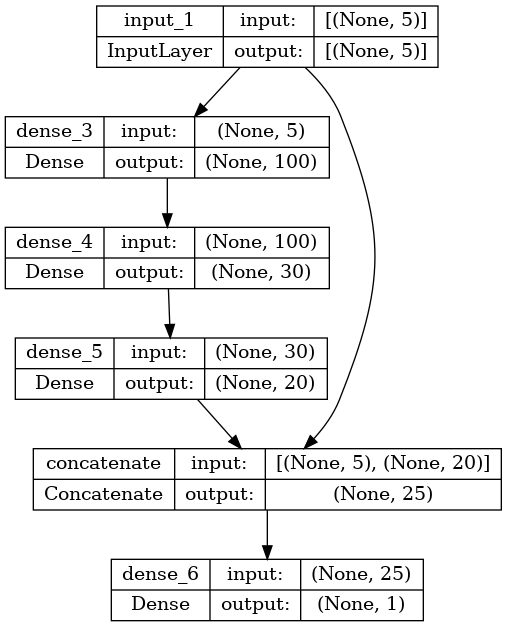

In [25]:
keras.utils.plot_model(
    n_net,
    "fully-connected-nn.png",
    show_shapes=True
)

**Exercise 2**: Call the `n_net.compile()` method with the appropriate loss function for regression (see your notes), the same metric we used on week 3 to evaluate our regressors (do you remember which one it was?), an SGD optimizer with a reasonable learning rate. Then train the network for 50 epochs, or a smaller number if the algorithm takes too long to go through each epoch, passing both the training and the validation set. When you are happy with your learning rate, then evaluate your model on the test set and print out MSE and RMSE as conputed on the test set.

In [26]:
# Write your code here: compile and train
n_net.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=[keras.metrics.RootMeanSquaredError()]
)
history = n_net.fit(
    X_train, y_train, epochs=200,
    validation_data=(X_val, y_val)
)

Epoch 1/200
380/380 [==============================] - 1s 2ms/step - loss: 126026416128.0000 - root_mean_squared_error: 355002.0000 - val_loss: 98892505088.0000 - val_root_mean_squared_error: 314471.7812
Epoch 2/200
380/380 [==============================] - 1s 1ms/step - loss: 102848929792.0000 - root_mean_squared_error: 320700.6875 - val_loss: 83898474496.0000 - val_root_mean_squared_error: 289652.3438
Epoch 3/200
380/380 [==============================] - 1s 1ms/step - loss: 90378043392.0000 - root_mean_squared_error: 300629.4062 - val_loss: 80643989504.0000 - val_root_mean_squared_error: 283978.8438
Epoch 4/200
380/380 [==============================] - 1s 1ms/step - loss: 82928558080.0000 - root_mean_squared_error: 287973.1875 - val_loss: 70964912128.0000 - val_root_mean_squared_error: 266392.4062
Epoch 5/200
380/380 [==============================] - 1s 2ms/step - loss: 78436827136.0000 - root_mean_squared_error: 280065.7500 - val_loss: 67581493248.0000 - val_root_mean_squared_er

What do you see happening? If you notice somthing amiss, try some bounded activation function (i.e. sigmoid or tanh). Other option could be different data scaling techniques such as quantile scaling (https://en.wikipedia.org/wiki/Quantile_normalization).

In [ ]:
# Write your code here: test set evaluation


How does the RMSE of this Neural Network compares to the one we obtained from the Regression algorithms we tried in Week 3?

## 6.3 Using the Subclassing API to Build Dynamic Models

Both the two APIs we have seen so far, the Sequential and the Functional, are declarative. This means that you declare which layers you are going to use and how they will be connected. Afterwards, you can start to feed the model some data for training or inference. There are a few advantages in this approach: 
* the model can easily be saved, cloned, and shared; 
* its structure can be displayed and analysed; 
* the framework can infer shapes and check types, so errors can be caught early. 
* It’s also fairly easy to debug, given that the whole model is a static graph of layers. 

However, the main disadvantage is just that the model is static. Some networks involve loops, varying shapes, conditional branching, and other dynamic behaviors. For these cases, or just if you favour a more imperative programming style, you can use the Subclassing API

What you have to do is: subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in a `call()` method. 

Let's see how we can do it with the "Wide & Deep" model we have seen in the previous section.

In [ ]:
class WideAndDeepNetwork(keras.models.Model):
    
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs) # handles standard args, such as 'name'
        self.hidden_0 = keras.layers.Dense(units, activation=activation)
        self.hidden_1 = keras.layers.Dense(units, activation=activation)
        self.output_0 = keras.layers.Dense(1)
        
    def call(self, inputs):
        hidden_0 = self.hidden_0(inputs)
        hidden_1 = self.hidden_1(hidden_0)
        concat = keras.layers.concatenate([inputs, hidden_1])
        return self.output_0(concat)
    
n_net = WideAndDeepNetwork(30, activation='tanh')
n_net

This example looks very much like the Functional API, except we do not need to create the inputs; we just use the input argument to the call() method, and we separate the creation of the layers21 in the constructor from their usage in the call() method. The big difference is that you can do pretty much anything you want in the call() method: for loops, if statements, low-level TensorFlow operations—your imagination is the limit! This makes it a great API for researchers experimenting with new ideas.

This extra flexibility does come at a cost: your model’s architecture is hidden within the call() method, so Keras cannot easily inspect it; it cannot save or clone it; and when you call the summary() method, you only get a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. So unless you really need that extra flexibility, you should probably stick to the Sequential API or the Functional API.

In [ ]:
n_net.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(lr=0.01),
    metrics=[keras.metrics.RootMeanSquaredError()]
)
history = n_net.fit(
    X_train, y_train, epochs=30,
    validation_data=(X_val, y_val)
)
mse, rmse = n_net.evaluate(X_test, y_test, verbose=0)

In [ ]:
rmse

## 6.4 Using TensorBoard for Visualization

Tensorboard is an interactive tool, shipped together with TensorFlow, that helps to visualise and comprare the training performance of your network.

Before we can use it, we need to modify our code to output log files that are named "event files". TensorBoard will pick up these files as soon as they are created and visualise them.

In [27]:
# to be done
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    """
    This method will generate a different directory with name based on creation timestamp
    every time we run the code
    """
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() 
run_logdir

'./my_logs/run_2022_07_15-17_58_20'

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Here rather than using SGD optimiser and tanh as activation function, we are going to use a more up-to-date approach to avoid the issue of vanishing exploding/gradients: we will use the SeLU activation function and the improved "Adam" optimisation algorithm (see Notebook 06B).

In [29]:
n_net = keras.models.Sequential([
    keras.layers.Dense(
        100, activation="selu", kernel_initializer='lecun_normal', input_shape=[5]
    ),
    keras.layers.Dense(
        30, activation="selu", kernel_initializer='lecun_normal'
    ),
    keras.layers.Dense(1)
])

n_net.compile(
    loss="mse", 
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

/home/massi/.pyenv/versions/anaconda3-2022.05/envs/tf-data-science/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
dense_1 = n_net.get_layer('dense_1')

In [ ]:
dense_1.activation

In [30]:
n_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               600       
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,661
Trainable params: 3,661
Non-trainable params: 0
_________________________________________________________________


We can use Keras's `TensorBoard()` callbacks to create a log directory and the event files:

In [31]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = n_net.fit(X_train, y_train, epochs=40, 
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_cb])

Epoch 1/40
380/380 [==============================] - 2s 3ms/step - loss: 429796753408.0000 - root_mean_squared_error: 655588.8750 - val_loss: 421441830912.0000 - val_root_mean_squared_error: 649185.5000
Epoch 2/40
380/380 [==============================] - 1s 2ms/step - loss: 425957294080.0000 - root_mean_squared_error: 652654.0625 - val_loss: 414362009600.0000 - val_root_mean_squared_error: 643709.5625
Epoch 3/40
380/380 [==============================] - 1s 2ms/step - loss: 414864310272.0000 - root_mean_squared_error: 644099.6250 - val_loss: 398664957952.0000 - val_root_mean_squared_error: 631399.1875
Epoch 4/40
380/380 [==============================] - 1s 2ms/step - loss: 394771628032.0000 - root_mean_squared_error: 628308.5625 - val_loss: 373629288448.0000 - val_root_mean_squared_error: 611252.2500
Epoch 5/40
380/380 [==============================] - 1s 2ms/step - loss: 365402587136.0000 - root_mean_squared_error: 604485.3750 - val_loss: 339577110528.0000 - val_root_mean_squared

In [ ]:
%load_ext tensorboard  # or %reload_ext tensorboard
%tensorboard --logdir=./my_logs --port=6007

In [32]:
# if the cell above throws some errors try this one:
!python -m tensorboard.main --logdir=./my_logs

2022-07-15 18:00:28.198867: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-15 18:00:28.198905: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pc323
2022-07-15 18:00:28.198912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pc323
2022-07-15 18:00:28.199040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-07-15 18:00:28.199065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-07-15 18:00:28.199073: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expos

## 6.5 Fine-Tuning Neural Network Hyperparameters

Just as we had the same issue with other machine learning algorithms, neural networks have many hyperparamenters, even more so. (1) You can use any possible architecture you can conceive, (2) you can tweak the number of layers and (3) the number of neural units per layer, (4) the activation nonlinear function in each layer, and more...

A possibility to explore the parameter space is to wrap our Keras model in an object with the same interface as a typical Scikit-Learn regressor or classifier

To do so, we can define a function that builds and compiles a Keras network, given a set of hyperparameters:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def build_network(
    n_hidden=1,
    n_neurons=100,
    activation="selu", 
    learning_rate=5e-3,
    input_shape=[13],
    kernel_initializer='lecun_normal'
):
    n_net = keras.models.Sequential()
    n_net.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        n_net.add(keras.layers.Dense(
            n_neurons, activation=activation, kernel_initializer=kernel_initializer
        ))
    n_net.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    n_net.compile(
        loss=keras.losses.mean_squared_error,
        optimizer=optimizer,
        metrics=[keras.metrics.RootMeanSquaredError()]
    )
    return n_net

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_network)

In [ ]:
keras_reg.fit(
    X_train,
    y_train,
    epochs=100, 
    validation_data=(X_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

In [ ]:
rmse_test = np.sqrt(-keras_reg.score(X_test, y_test, verbose=0))
rmse_test

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

**Exercise:** set up a `RandomizedSearchCV` object to explore 12 combinations from a grid of parameters on the wrapped NeuralNet `keras_reg`, using 3-fold cross validation, training the network for 20 or 100 epochs and allowing for early stopping by using the callback `keras.callbacks.EarlyStopping` with a reasonable patience (check the early-stopping API.)

The range of parameters you *may* want to try in your param grid are:
 * number of hidden layers: from 1 to 3
 * number of neurons in each layer: 10, 20, 30, 40, 50
 * learning rate: a good approach for the learning rate is to use a reciprocal distribution with quantiles lower_bound = $0.0001$ and upper_bound = $0.01$. See more about reciprocal distributions here: https://en.wikipedia.org/wiki/Reciprocal_distribution. In order to set the reciprocal distribution, you can use the `reciprocal` function from the `scipy.stats` module. A simpler approach would be to pass a list of discrete values, e.g [0.0001, 0.0005, ..., 0.01]. Follow this approach if the other seems too obscure.
 * activation: 'relu', 'selu'   (see Notebook 06B)
 * kernel_initializer: 'glorot_uniform', 'lecun_normal'  (see Notebook 06B)
 
Feel free to modify the options in this grid

Check `RandomizedSearchCV` API on scikit-learn for more info.

Please note that this cell will take a while to run.

In [ ]:
# Optional: you can use `rec_dist` as defined here to set your learning rate interval
from scipy.stats import reciprocal
reciprocal(5e-4, 1e-2)

In [ ]:
# Write your code here:
EPOCHS = ... # complete me...
rnd_search_cv = ... # complete me

Now here you can identify the best params combination and the best score you achieved:

In [ ]:
%%capture --no-stderr
rnd_search_cv.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=0
)

In [ ]:
rnd_search_cv.best_params_, rnd_search_cv.best_score_